# EDA-Stackoverflow

In [83]:
#data structures
import pandas as pd
import numpy as np
from collections import defaultdict
from collections import Counter
import string
import json

# html
import requests 
import requests_cache
from bs4 import BeautifulSoup

# visualization
import matplotlib as mpl
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns

# statistics
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import stats
import statistics

# text processing
import nltk
from textblob import TextBlob
from nltk import corpus
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import re

# other
import time
import pprint as pp
import operator
import progressbar
import itertools
from time import sleep
import datetime
import calendar
from collections import Counter, defaultdict

from pprint import pprint


from math import isnan

In [53]:
# setup
requests_cache.install_cache('aggie_cache')
plt.style.use('ggplot')

In [55]:
#packages used by textblob
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
nltk.download("brown")
nltk.download("wordnet")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /Users/esmondchu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/esmondchu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package brown to /Users/esmondchu/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/esmondchu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/esmondchu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Load Data

In [104]:
Posts = pd.read_csv('../../160-Stackoverflow-Data/300000_rows/Posts.csv', \
                    dtype = {'LastEditorDisplayName': str, 'Tags': str})
Comments = pd.read_csv('../../160-Stackoverflow-Data/300000_rows/Comments.csv')
Votes = pd.read_csv('../../160-Stackoverflow-Data/300000_rows/Votes.csv')

## Timely Collaboration and Values

In [9]:
#date to timestamp
def date_ts(s):
    """ 
    param s: str - date
    returns: int - timestamp
    """
    date = datetime.datetime.strptime(s, "%Y-%m-%dT%H:%M:%S")
    st = calendar.timegm(date.utctimetuple())
    return(st)

In [10]:
#Answer posts
df_answers = Posts[Posts.PostTypeId == 2]

In [11]:
df_answers = df_answers.reset_index(drop=True)

In [27]:
df_answers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152190 entries, 0 to 152189
Data columns (total 20 columns):
Id                       152190 non-null int64
PostTypeId               152190 non-null int64
ParentID                 152190 non-null float64
AcceptedAnswerId         0 non-null float64
CreationDate             152190 non-null object
Score                    152190 non-null int64
ViewCount                0 non-null float64
Body                     152190 non-null object
OwnerUserId              152068 non-null float64
LastEditorUserId         41415 non-null float64
LastEditorDisplayName    34 non-null object
LastEditDate             41448 non-null object
LastActivityDate         152190 non-null object
CommunityOwnedDate       239 non-null object
ClosedDate               0 non-null object
Title                    0 non-null object
Tags                     0 non-null object
AnswerCount              0 non-null float64
CommentCount             152190 non-null int64
FavoriteCount 

In [12]:
df_answers.CreationDate = df_answers.CreationDate.str[:-4]

In [13]:
unix_ans = [date_ts(i) for i in df_answers.CreationDate]

In [14]:
df_answers_time = pd.DataFrame({'ParentID':df_answers.ParentID, 'Cr_time':unix_ans})

In [15]:
df_list = df_answers_time.groupby(df_answers_time.ParentID)

In [16]:
uni_par_id = list(df_answers_time.ParentID.unique())

In [17]:
ans_date = [list(df_list.get_group(i).Cr_time) for i in uni_par_id]

In [18]:
yes = 0
no = 0
for i in ans_date:
    if len(i) == 1:
        yes += 1
    else:
        no += 1
print(yes, no)

#there are 2917 posts with only 1 answer, 15773 posts with more than 1 answers.

87571 26874


In [19]:
#set 1-answer post sd to 0
for i in ans_date:
    if len(i) == 1:
        i.append(i[0])
    else:
        i == i

In [21]:
#Get standard deviation for answers
ans_time_sd = [statistics.stdev(i) for i in ans_date]

In [22]:
post_Id = sorted(list(df_answers.ParentID.unique()))

In [23]:
post_ans_sd = pd.DataFrame({'post_Id':post_Id, 'time_sd':ans_time_sd})

In [24]:
#Parents posts
Parents_post = Posts[Posts.PostTypeId == 1]

In [25]:
Parents_post = Parents_post.reset_index(drop=True)

In [26]:
Parents_post.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147447 entries, 0 to 147446
Data columns (total 20 columns):
Id                       147447 non-null int64
PostTypeId               147447 non-null int64
ParentID                 0 non-null float64
AcceptedAnswerId         41108 non-null float64
CreationDate             147447 non-null object
Score                    147447 non-null int64
ViewCount                147447 non-null float64
Body                     147447 non-null object
OwnerUserId              147167 non-null float64
LastEditorUserId         73457 non-null float64
LastEditorDisplayName    82 non-null object
LastEditDate             73534 non-null object
LastActivityDate         147447 non-null object
CommunityOwnedDate       0 non-null object
ClosedDate               10922 non-null object
Title                    147447 non-null object
Tags                     147447 non-null object
AnswerCount              147447 non-null float64
CommentCount             147447 non-null

In [28]:
df_parents = pd.DataFrame({'post_Id':Parents_post.Id, 'Views_count':Parents_post.ViewCount,\
                           'Score':Parents_post.Score, 'Comment_count':Parents_post.CommentCount})

In [29]:
df_comb = df_parents.join(post_ans_sd.set_index('post_Id'), on='post_Id')

In [30]:
df_comb = df_comb.dropna()
df_comb = df_comb.reset_index(drop=True)

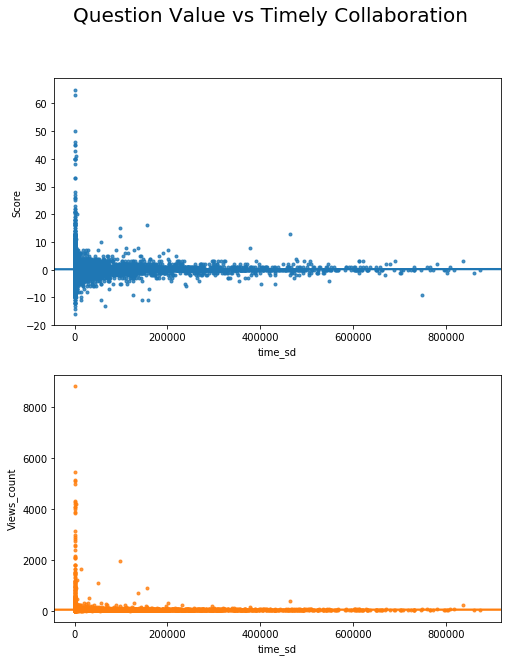

In [31]:
f, (ax1, ax2) = plt.subplots(nrows=2, figsize=(8,10))
plt.suptitle("Question Value vs Timely Collaboration", size=20)
sns.regplot(df_comb.time_sd, df_comb.Score, marker=".", ax=ax1)
sns.regplot(df_comb.time_sd, df_comb.Views_count, marker=".", ax=ax2)

## How many questions are left unanswered?

In [65]:
n_questions = len(Posts.loc[Posts.PostTypeId == 1])
n_unanswered = len(Posts.loc[(Posts.PostTypeId == 1) & (Posts.AcceptedAnswerId.isnull())])
print(f'Approximately {n_unanswered/n_questions*100}% of questions remain with nonaccepted answers.')

Approximately 72.12015164771071% of questions remain with nonaccepted answers.


In [66]:
# in what context does only 28% of questions get answered?
Posts.CreationDate = pd.to_datetime(Posts.CreationDate, format="%Y-%m-%dT%H:%M:%S")
Posts_sorted = Posts.sort_values(by=['CreationDate'])
earliest_date = Posts_sorted.iloc[0]['CreationDate']
latest_date = Posts_sorted.iloc[-1]['CreationDate']

print(f'In the context of our sample, the earliest post was {earliest_date} and the latest post was {latest_date}.')
print('Which suggests that within a 3 month timespan only a quarter of posted questions get answered.')

In the context of our sample, the earliest post was 2018-01-26 19:05:05.213000 and the latest post was 2018-03-11 04:55:43.843000.
Which suggests that within a 3 month timespan only a quarter of posted questions get answered.


In [67]:
# how many questions get absolutely no answers?
# there should only ever be a unique post id per question
n_questions = len(Posts.loc[Posts.PostTypeId == 1])

# to obtain the number of answers, we count the number of unique parent ids,
n_answers = len(set(Posts.loc[(Posts.PostTypeId == 2)].ParentID.values))
print(f'Approximately {(1 - (n_answers/n_questions))*100}% of questions remain unanswered.')

Approximately 22.382279734413046% of questions remain unanswered.


## What is the ratio of questions without an accepted answer?

In [86]:
QUESTION = 1
ANSWER = 2
UP = 2
DOWN = 3

In [87]:
Posts['ParentID'] = Posts['ParentID'].fillna(0).astype(int)
Posts['AcceptedAnswerId'] = Posts['AcceptedAnswerId'].fillna(0).astype(int)

In [88]:
questions = Posts[Posts['PostTypeId'] == 1]
unanswered = questions[questions['AcceptedAnswerId'] == 0]

In [92]:
print('The ratio of questions without an accepted answer: ', len(unanswered) / len(questions))

The ratio of questions without an accepted answer:  0.7212015164771071


## 15 most upvoted questions that are unanswered.

In [94]:
unanswered.rename(columns = {'Id':'PostId'}, inplace = True)
upvotes = Votes[Votes['VoteTypeId'] == UP]

/Users/esmondchu/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:2746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [96]:
no_ans_q = questions[questions['AnswerCount'] == 0]
no_ans_q.rename(columns = {'Id':'PostId'}, inplace = True)
uv_no_ans = upvotes.join(no_ans_q.set_index('PostId'), on='PostId', how='inner', lsuffix='_x')

/Users/esmondchu/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:2746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [97]:
top_uv_no_ans = Counter(uv_no_ans['PostId']).most_common(15)

In [98]:
unanswered.sort_values(by='Score',ascending=False)[:15]

,PostId,PostTypeId,ParentID,AcceptedAnswerId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastEditorUserId,LastEditorDisplayName,LastEditDate,LastActivityDate,CommunityOwnedDate,ClosedDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount
8705,48881018,1,0,0,2018-02-20T08:45:23.187,45,3840.0,"<p>I stumbled through an example from ""<em>Eff...",6098812.0,3982001.0,NaN,2018-03-08T13:55:12.227,2018-03-08T13:55:12.227,NaN,NaN,Cost of Default parameters in C++,<c++><performance><default-parameters>,3.0,12,4.0
147255,49043684,1,0,0,2018-03-01T06:18:10.773,40,815.0,<p>A grid is implemented using the CSS flexbox...,247243.0,8620333.0,NaN,2018-03-03T20:53:38.007,2018-03-10T16:16:15.097,NaN,NaN,How to calculate the amount of flexbox items i...,<javascript><html><css><css3><flexbox>,11.0,8,13.0
202788,49107252,1,0,0,2018-03-05T09:36:49.347,33,2081.0,<p>I want to know if it's possible to change t...,1734974.0,NaN,NaN,NaN,2018-03-07T22:46:52.477,NaN,NaN,Change text size and color incrementally,<javascript><html><css>,5.0,4,9.0
30347,48906338,1,0,0,2018-02-21T12:47:11.460,28,580.0,<pre><code>#include &lt;cstdio&gt;\r\n#include...,4140668.0,4140668.0,NaN,2018-03-01T04:26:08.500,2018-03-01T04:26:08.500,NaN,NaN,Why can't gcc devirtualize this function call?,<c++><gcc><compiler-optimization>,2.0,8,3.0
123355,49015858,1,0,0,2018-02-27T18:46:25.080,25,2386.0,<p>I have searched and searched for an answer ...,9420401.0,9420401.0,NaN,2018-02-27T18:48:59.570,2018-03-04T11:28:10.013,NaN,2018-02-28T03:14:22.233,What real use does a double pointer have?,<c++><pointers>,11.0,11,1.0
156521,49054406,1,0,0,2018-03-01T16:31:23.937,22,404.0,<h1>How to get rid of unnecessary root layouts...,9280279.0,9280279.0,NaN,2018-03-08T12:15:25.130,2018-03-10T13:32:17.427,NaN,NaN,Get rid of unnecessary root layouts for fullsc...,<android><android-layout><android-activity><ko...,4.0,2,4.0
64636,48946639,1,0,0,2018-02-23T11:16:48.907,21,293.0,<p>The command <code>jupyter notebook</code> w...,1585017.0,1585017.0,NaN,2018-02-23T14:28:07.030,2018-03-06T07:46:36.467,NaN,NaN,How to create and open a jupyter notebook ipyn...,<python><terminal><jupyter-notebook>,5.0,0,0.0
135129,49029515,1,0,0,2018-02-28T12:23:18.837,18,800.0,"<p>Objective-C declares a class function, init...",64949.0,603977.0,NaN,2018-03-04T16:40:48.727,2018-03-09T17:18:11.513,NaN,NaN,Is there an alternative to initialize() in mac...,<swift><macos><swizzling>,5.0,11,5.0
14510,48887802,1,0,0,2018-02-20T14:42:27.910,18,922.0,<p>Is there a function which accepts a referen...,4990642.0,964243.0,NaN,2018-02-21T13:09:57.703,2018-02-26T06:36:52.513,NaN,NaN,Determine if a lambda expression is stateless ...,<java><lambda><java-8><java-9>,4.0,14,8.0
16183,48889736,1,0,0,2018-02-20T16:22:29.503,16,137.0,"<p>The <a href=""https://github.com/webpack-con...",4046605.0,2501450.0,NaN,2018-02-22T14:40:58.697,2018-03-01T17:03:00.623,NaN,NaN,css-loader localIdentName: is a hash necessary...,<css><reactjs><webpack><css-modules><css-loader>,2.0,0,NaN


## What is the mean and median response for a question for each of the 20 most popular tags?

In [101]:
#need to upload later

## Probability of a question being answered as a function of time in minutes

In [99]:
#rerun
Posts = pd.read_csv('../../160-Stackoverflow-Data/300000_rows/Posts.csv', \
                    dtype = {'LastEditorDisplayName': str, 'Tags': str})

In [32]:
#Parents Post Data Wrangling
parents_time = Parents_post.CreationDate.str[:-4]

In [33]:
unix_parents = [date_ts(i) for i in parents_time]

In [34]:
df_parents_time = pd.DataFrame({'Cr_time_parents':unix_parents, 'ParentID':Parents_post.Id})

In [35]:
#Merge Table & Create Columns of mins and hours¶
df_compare = pd.merge(df_parents_time, df_answers_time, on='ParentID')

In [36]:
df_compare['Duration'] = df_compare.Cr_time - df_compare.Cr_time_parents

In [37]:
df_compare['Duration_mins'] = df_compare.Duration/60

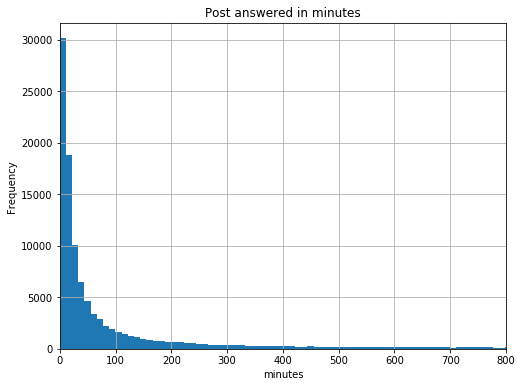

In [38]:
#Histogram
df_compare.Duration_mins.plot(kind = 'hist', bins=5000, figsize=(8,6))
plt.xlim(0,800)
plt.xlabel('minutes')
plt.title('Post answered in minutes')
plt.grid()

In [39]:
df_compare.Duration_mins.describe()

count    121385.000000
mean        609.633554
std        1971.848971
min           0.000000
25%          11.166667
50%          35.833333
75%         216.283333
max       55468.600000
Name: Duration_mins, dtype: float64

In [42]:
#Calculate Frequency and Probability of mins

In [43]:
Duration_mins_rounded = df_compare.Duration_mins.round()

In [44]:
fre_mins = pd.DataFrame(Duration_mins_rounded.value_counts(), index=None)
fre_mins['mins'] = fre_mins.index
fre_mins = fre_mins.rename(columns={'Duration_mins':'Frequency','mins':'mins'})
fre_mins.reset_index(inplace=True, drop=True)
fre_mins = fre_mins.sort_values('mins')

In [46]:
fre_mins['Probabiity'] = fre_mins.Frequency/sum(fre_mins.Frequency)

In [48]:
fre_mins.Probabiity.describe()

count    7470.000000
mean        0.000134
std         0.001140
min         0.000008
25%         0.000008
50%         0.000016
75%         0.000033
max         0.029600
Name: Probabiity, dtype: float64

In [49]:
#Cumulative Probability
fre_mins['cum_pro'] = np.cumsum(list(fre_mins.Probabiity))

Text(0.5,1,'cumulative probability')

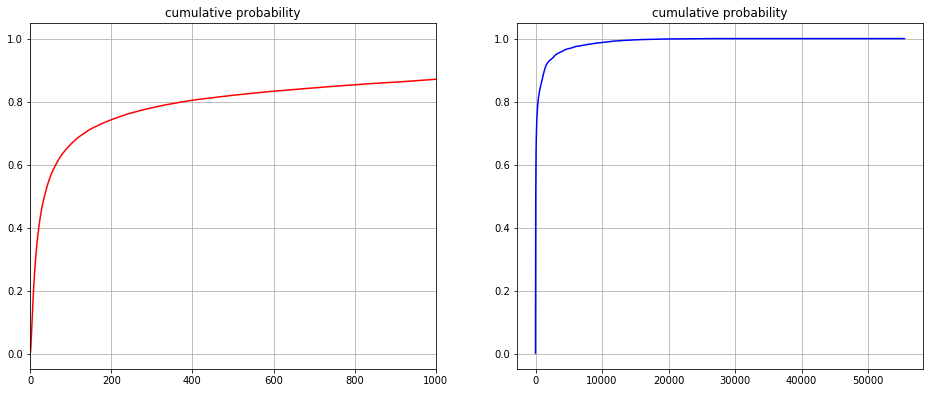

In [51]:
fig=plt.figure(figsize=(16,14))
plt.subplot(221)
plt.plot(fre_mins.mins, fre_mins.cum_pro, color='red')
plt.xlim(0,1000)
plt.grid()
plt.title('cumulative probability')
plt.subplot(222)
plt.plot(fre_mins.mins, fre_mins.cum_pro, color='blue')
plt.grid()
plt.title('cumulative probability')